In [129]:
import numpy as np
import pandas as pd
import ipdb
import pickle
import nnkcde
from cdetools.cdf_coverage import cdf_coverage
from cdetools.plot_utils import plot_with_uniform_band
from scipy.stats import norm, gamma, multivariate_normal, expon
from scipy.integrate import simps
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
from scipy.special import expit, logit
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.ticker import NullFormatter
import seaborn as sns

# really simple example

In [146]:
n = 10000

In [147]:
x_normal = norm.rvs(loc=1, scale=1, size=n)

In [148]:
print(x_normal.mean())
print(x_normal.var())

0.9830867015732594
0.9821350036966845


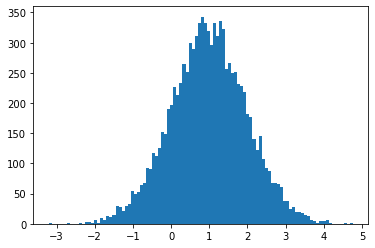

In [149]:
plt.hist(x_normal, bins=100)
plt.show()

In [152]:
x_expon = expon.rvs(loc=0, scale=1, size=n)

In [153]:
print(x_expon.mean())
print(x_expon.var())

0.9856714322484637
0.9839347077028998


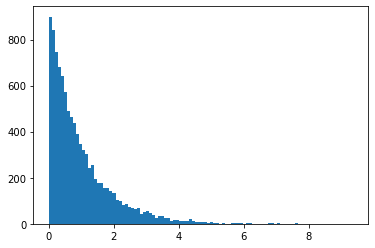

In [154]:
plt.hist(x_expon, bins=100)
plt.show()

In [155]:
KL_Ndata_Nmodel = -1/n * np.sum(np.log(norm.pdf(x=x_normal, loc=1, scale=1)))
KL_Ndata_Nmodel

1.4101490648848511

In [156]:
KL_Edata_Nmodel = -1/n * np.sum(np.log(norm.pdf(x=x_expon, loc=1, scale=1)))
KL_Edata_Nmodel

1.4110085409830277

In [157]:
KL_Edata_Emodel = -1/n * np.sum(np.log(expon.pdf(x=x_expon, loc=0, scale=1)))
KL_Edata_Emodel

0.9856714322484638

In [165]:
KL_Edata_Emodel1 = -1/n * np.sum(np.log(expon.pdf(x=x_expon, loc=-0.5, scale=1)))
KL_Edata_Emodel1

1.4856714322484637

In [166]:
x_expon1 = expon.rvs(loc=-0.5, scale=1, size=n)

In [168]:
print(x_expon1.mean())
print(x_expon1.var())

0.5067668451648948
1.0312453097574328


In [181]:
xrange = np.linspace(start=-4, stop=8, num=120)
normal_pdf = pd.Series([norm.pdf(x, loc=0, scale=1) for x in xrange], index=xrange)
expon_pdf = pd.Series([expon.pdf(x, loc=0, scale=1) for x in xrange], index=xrange)
expon_error_pdf = pd.Series([expon.pdf(x, loc=-0.5, scale=1) for x in xrange], index=xrange)

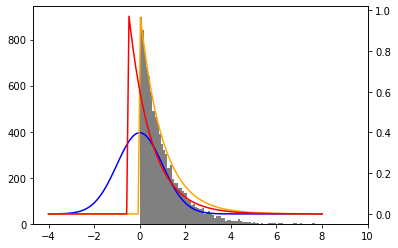

In [194]:
fig, ax1 = plt.subplots()

ax1.hist(x_expon, bins=100, color='gray')

ax2 = ax1.twinx()
ax2.plot(normal_pdf, color='blue', label='normal')
ax2.plot(expon_pdf, color='orange', label='normal')
ax2.plot(expon_error_pdf, color='red', label='normal')
plt.show()

In [158]:
KL_Ndata_Emodel = -1/n * np.sum(np.log(expon.pdf(x=x_normal, loc=0, scale=1)))
KL_Ndata_Emodel

C:\Users\dzhao\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


inf

# MVN different magnitude directions
# $X \sim N([100,1], \textrm{diag}([100,1])) $

In [121]:
mean = [10,1]
cov = [[1,0],[0,1]]

In [122]:
def sample_MVN(size=10000, mean=mean, cov=cov, seed=6):
    np.random.seed(seed)
    x_sample = multivariate_normal.rvs(mean=mean, cov=cov, size=size)
    return x_sample

In [123]:
n = 100
x_sample = sample_MVN(size=n)

In [124]:
KL_right = -1/n * np.sum(np.log(multivariate_normal.pdf(x=x_sample, mean=mean, cov=cov)))
KL_right

2.772159402764769

In [125]:
KL_right = -1/n * np.sum(np.log(multivariate_normal.pdf(x=x_sample, mean=[11,1], cov=cov)))
KL_right

3.2451876312087444

In [126]:
KL_right = -1/n * np.sum(np.log(multivariate_normal.pdf(x=x_sample, mean=[10,0.9], cov=cov)))
KL_right

2.7751315717848573

# GMM with 3 different means
# $X \sim 0.45N([0,0],I_2) + 0.45N([3,1],I_2) + 0.1N([1,3],I_2)$

In [50]:
def sample_GMM(size=10000, p1=0.45, p2=0.45, loc1=[0,0], loc2=[3,1], loc3=[1,4], seed=6):
    np.random.seed(seed)
    inds = np.random.choice(a=[1,2,3], size=size, p=[p1,p2,1-p1-p2])
    ind_mix1 = 1*(inds == 1)
    ind_mix2 = 1*(inds == 2)
    ind_mix3 = 1*(inds == 3)
    mix1 = multivariate_normal.rvs(mean=loc1, cov=1, size=size)
    mix2 = multivariate_normal.rvs(mean=loc2, cov=1, size=size)
    mix3 = multivariate_normal.rvs(mean=loc3, cov=1, size=size)
    x_sample = np.vstack([ind_mix1, ind_mix1]).T *mix1 + np.vstack([ind_mix2, ind_mix2]).T *mix2 + \
        np.vstack([ind_mix3, ind_mix3]).T *mix3
    return x_sample

In [65]:
def calc_pdf_GMM(x, p1=0.45, p2=0.45, loc1=[0,0], loc2=[3,1], loc3=[1,4]):
    pdf = p1*multivariate_normal.pdf(x=x, mean=loc1, cov=1) + p2*multivariate_normal.pdf(x=x, mean=loc2, cov=1) + \
        (1-p1-p2)*multivariate_normal.pdf(x=x, mean=loc3, cov=1)
    return pdf

In [81]:
def calc_pdf_EM3(x, gm):
    p1 = gm.weights_[0]
    p2 = gm.weights_[1]
    loc1 = gm.means_[0]
    loc2 = gm.means_[1]
    loc3 = gm.means_[2]
    scale1 = np.sqrt(gm.covariances_[0])
    scale2 = np.sqrt(gm.covariances_[1])
    scale3 = np.sqrt(gm.covariances_[2])
    pdf = p1*norm.pdf(x=x, loc=loc1, scale=scale1) + p2*norm.pdf(x=x, loc=loc2, scale=scale2) + \
        (1-p1-p2)*norm.pdf(x=x, loc=loc3, scale=scale3)
    return pdf

In [82]:
def calc_pdf_EM2(x, gm):
    p = gm.weights_[0]
    loc1 = gm.means_[0]
    loc2 = gm.means_[1]
    scale1 = np.sqrt(gm.covariances_[0])
    scale2 = np.sqrt(gm.covariances_[1])
    pdf = p*norm.pdf(x=x, loc=loc1, scale=scale1) + (1-p)*norm.pdf(x=x, loc=loc2, scale=scale2)
    return pdf

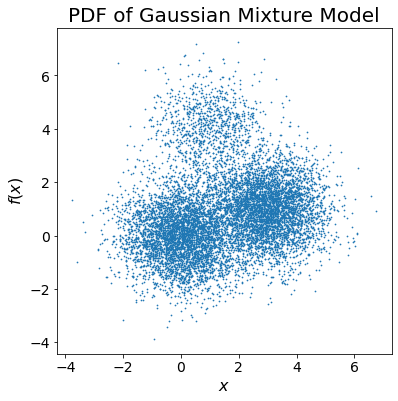

In [51]:
fig = plt.figure(figsize=(6,6))

x_sample = sample_GMM(size=10000)

plt.scatter(x_sample[:,0], x_sample[:,1], s=0.5)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('PDF of Gaussian Mixture Model', fontsize=20)
#plt.legend(fontsize=14)

plt.show()

In [72]:
gm2 = GaussianMixture(n_components=2, random_state=6, covariance_type='spherical').fit(x_sample.reshape(-1,2))
gm3 = GaussianMixture(n_components=3, random_state=6, covariance_type='spherical').fit(x_sample.reshape(-1,2))

In [68]:
gm3.weights_

array([0.44457032, 0.44665322, 0.10877647])

In [69]:
gm3.means_

array([[ 0.01458876, -0.03656293],
       [ 3.01651822,  0.95728712],
       [ 1.01498648,  3.91084675]])

In [70]:
gm3.covariances_

array([0.98086337, 0.94711441, 1.09593071])

In [73]:
gm2.weights_

array([0.33319138, 0.66680862])

In [74]:
gm2.means_

array([[-0.17801017, -0.15919425],
       [ 2.28482557,  1.33437209]])

In [75]:
gm2.covariances_

array([0.83210458, 2.22315264])

### compute KL divergence

In [60]:
n = 10000

In [83]:
KL_EM = -1/n * np.sum(np.log(calc_pdf_EM3(x_sample, gm3)))
KL_EM

3.699257155680573

In [84]:
KL_EM = -1/n * np.sum(np.log(calc_pdf_EM2(x_sample, gm2)))
KL_EM

3.7560618363602387

In [66]:
-1/n * np.sum(np.log(calc_pdf_GMM(x_sample)))

3.600064777260199